In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import os
import cv2 as cv

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet201

In [ ]:
def load_images_from_folder(folder,preprocess=True):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(filename)
        if img is not None:
          if preprocess:
             img=preprocess_input(img)
          images.append(img)
    return np.array(images)

In [ ]:
data_path=os.getcwd()

In [ ]:
base_model=DenseNet201(input_shape=[128,128,3],weights='imagenet',include_top=False) 

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
damage_X=load_images_from_folder(data_path)
damage_y=load_images_from_folder(data_path,preprocess=False)

In [ ]:
damage_y.shape

(2, 128, 128, 3)

In [ ]:
for layer in base_model.layers[:10]:
    layer.trainable=False
encoder=keras.models.Sequential(base_model.layers[:10])
decoder=keras.models.Sequential()
decoder.add(keras.layers.Conv2DTranspose(32,kernel_size=2,strides=2,padding='same',activation='selu',input_shape=[32,32,128]))
decoder.add(keras.layers.Conv2DTranspose(3,kernel_size=2,strides=2,padding='same',activation='linear'))
#decoder.add(keras.layers.Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',activation='sigmoid'))
#decoder.add(keras.layers.Flatten())
#decoder.add(keras.layers.Dense(128*128*3,activation='sigmoid'))
#decoder.add(keras.layers.Reshape([128,128,3]))

In [ ]:
ae=keras.models.Sequential([encoder,decoder])

In [ ]:
ae.compile(loss='MSE',optimizer=keras.optimizers.Adam(lr=0.001))

In [ ]:
encoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 134, 134, 3)       0         
_________________________________________________________________
conv1/conv (Conv2D)          (None, 64, 64, 64)        9408      
_________________________________________________________________
conv1/bn (BatchNormalization (None, 64, 64, 64)        256       
_________________________________________________________________
conv1/relu (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_block1_0_bn (BatchNorm (None, 32, 32, 64)       

In [ ]:
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 32)        16416     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 3)       387       
Total params: 16,803
Trainable params: 16,803
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ae.fit(damage_X,damage_y,validation_split=0.1,initial_epoch=400,epochs=450)

Epoch 401/450
49/49 [==============================] - 1s 13ms/step - loss: 99.8514 - val_loss: 93.5918
Epoch 402/450
49/49 [==============================] - 1s 11ms/step - loss: 99.6999 - val_loss: 93.4980
Epoch 403/450
49/49 [==============================] - 1s 11ms/step - loss: 99.6665 - val_loss: 93.4220
Epoch 404/450
49/49 [==============================] - 1s 10ms/step - loss: 99.5879 - val_loss: 93.5257
Epoch 405/450
49/49 [==============================] - 1s 11ms/step - loss: 99.5913 - val_loss: 93.5746
Epoch 406/450
49/49 [==============================] - 1s 11ms/step - loss: 99.5985 - val_loss: 93.3604
Epoch 407/450
49/49 [==============================] - 1s 11ms/step - loss: 99.4861 - val_loss: 93.4470
Epoch 408/450
49/49 [==============================] - 1s 11ms/step - loss: 99.4323 - val_loss: 93.4822
Epoch 409/450
49/49 [==============================] - 1s 11ms/step - loss: 99.4036 - val_loss: 93.2876
Epoch 410/450
49/49 [==============================] - 1s 11ms/s

In [ ]:
sample=cv.imread('i.jpeg')
reconstruct=ae.predict(np.expand_dims(preprocess_input(sample),axis=0))

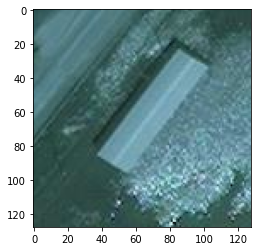

In [ ]:
plt.imshow(sample)

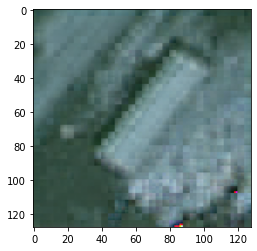

In [ ]:
plt.imshow(reconstruct[0].astype('uint8'))

In [ ]:
cv.imwrite('r9.png',reconstruct[0])

True

In [ ]:
decoder.save_weights('decoder-2.h5')

In [ ]:
from google.colab import files
files.download('decoder-2.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
decode=keras.models.Sequential()
decode.add(keras.layers.Conv2DTranspose(32,kernel_size=2,strides=2,padding='same',activation='selu',input_shape=[32,32,128]))
decode.add(keras.layers.Conv2DTranspose(3,kernel_size=2,strides=2,padding='same',activation='linear'))

In [ ]:
decode.load_weights('decoder-2.h5')

In [ ]:
for layer in base_model.layers[:10]:
    layer.trainable=False
encode=keras.models.Sequential(base_model.layers[:10])
ae=keras.models.Sequential([encode,decode])

In [ ]:
ae.compile(loss='MSE',optimizer=keras.optimizers.Adam(lr=0.001))

In [ ]:
#validation_another, damage, 193 images
#train_another, damage, 1715 images; validated on validation_another, damage